VXOCLS
CPIAUCSL
UNRATE
INDPRO
UMCSENT
STLFSI2
FEDFUNDS
T10Y2Y
PCEPI
PAYEMS
M2SL
RETAILSMSA
📌 Selected features via LASSO:
STLFSI2              4.046352
PAYEMS_zscore       -1.319901
M2SL_6m_chg          0.983876
FEDFUNDS_6m_chg     -0.797215
PCEPI               -0.773316
INDPRO_6m_chg        0.429805
T10Y2Y_6m_chg        0.355971
RETAILSMSA_6m_chg    0.333467
INDPRO_3m_chg        0.264811
FEDFUNDS             0.205112
STLFSI2_zscore       0.088545
M2SL_zscore         -0.040455
dtype: float64


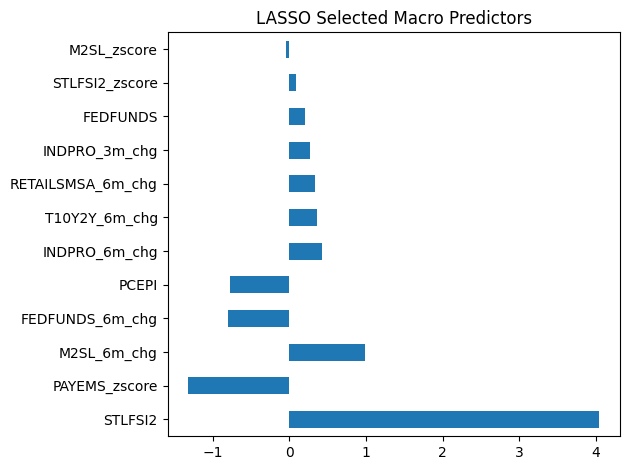

In [2]:
from fredapi import Fred
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Replace this with your own API key
fred = Fred(api_key="")

# Define FRED series
fred_series = {
    'VXOCLS': 'VIX proxy (target)',
    'CPIAUCSL': 'Inflation - CPI',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'UMCSENT': 'Consumer Sentiment',
    'STLFSI2': 'Financial Stress Index',
    'FEDFUNDS': 'Fed Funds Rate',
    'T10Y2Y': 'Yield Curve 10Y-2Y',
    'PCEPI': 'PCE Inflation',
    'PAYEMS': 'Nonfarm Payrolls',
    'M2SL': 'Money Supply M2',
    'RETAILSMSA': 'Retail Sales'
}

start = '1990-01-01'
end = '2024-12-31'
data = pd.DataFrame()

for code in fred_series:
    print(code)
    data[code] = fred.get_series(code, observation_start=start, observation_end=end)

data = data.resample('ME').last().dropna()
data['VXO_next'] = data['VXOCLS'].shift(-1)
data.dropna(inplace=True)

# Feature engineering
for col in data.columns:
    if col != 'VXO_next':
        data[f'{col}_3m_chg'] = data[col].pct_change(3)
        data[f'{col}_6m_chg'] = data[col].pct_change(6)
        data[f'{col}_zscore'] = (data[col] - data[col].rolling(12).mean()) / data[col].rolling(12).std()

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

features = [col for col in data.columns if 'VXO' not in col]
X = data[features]
y = data['VXO_next']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5, random_state=0, max_iter=50000).fit(X_scaled, y)
coefs = pd.Series(lasso.coef_, index=features)
selected_features = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print("📌 Selected features via LASSO:")
print(selected_features)

# Plot
selected_features.plot(kind='barh', title="LASSO Selected Macro Predictors")
plt.tight_layout()
plt.show()

In [3]:
columns = ["VXO_next", "VXOCLS"]
data[columns]

,VXO_next,VXOCLS
1995-03-31,14.56,13.58
1995-05-31,12.88,14.56
1995-06-30,11.99,12.88
1995-08-31,12.99,11.99
1995-09-30,12.05,12.99
...,...,...
2021-02-28,19.32,28.51
2021-03-31,17.27,19.32
2021-04-30,13.17,17.27
2021-06-30,16.21,13.17


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

selected_feature_names = selected_features.index.tolist()
X_selected = X[selected_feature_names]
# X_selected = X[features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

right_direction = 0
total = 0

previous_true = None
for pred, true in zip(y_pred, y_test):
    print(f"Predicted: {pred:.2f}, Actual: {true:.2f}")
    if previous_true is not None:
        if (pred > previous_true and true > previous_true) or (pred < previous_true and true < previous_true):
            right_direction += 1
        total += 1
    previous_true = true

print(right_direction, total)

R² Score: 0.5278058135260537
RMSE: 5.908452537846227
Predicted: 20.45, Actual: 16.84
Predicted: 13.85, Actual: 13.62
Predicted: 40.86, Actual: 45.85
Predicted: 23.27, Actual: 16.11
Predicted: 18.73, Actual: 13.17
Predicted: 29.33, Actual: 22.59
Predicted: 26.33, Actual: 21.70
Predicted: 16.90, Actual: 16.69
Predicted: 16.07, Actual: 22.16
Predicted: 15.49, Actual: 13.43
Predicted: 31.28, Actual: 35.28
Predicted: 20.09, Actual: 20.82
Predicted: 15.43, Actual: 11.16
Predicted: 22.54, Actual: 22.89
Predicted: 28.77, Actual: 25.41
Predicted: 25.34, Actual: 19.28
Predicted: 14.83, Actual: 18.23
Predicted: 14.25, Actual: 13.58
Predicted: 12.56, Actual: 19.85
Predicted: 15.33, Actual: 11.35
Predicted: 12.74, Actual: 11.12
Predicted: 22.44, Actual: 23.75
Predicted: 15.46, Actual: 13.44
Predicted: 23.63, Actual: 44.11
Predicted: 19.24, Actual: 16.54
Predicted: 25.96, Actual: 22.98
Predicted: 12.67, Actual: 10.36
Predicted: 27.56, Actual: 23.77
Predicted: 27.05, Actual: 23.51
Predicted: 14.86, A

In [5]:
coef_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nCoefficients:")
print(coef_df)


Coefficients:
              Feature  Coefficient
2         M2SL_6m_chg    65.064446
5       INDPRO_6m_chg    43.631368
8       INDPRO_3m_chg     6.228955
0             STLFSI2     4.768020
7   RETAILSMSA_6m_chg     3.834750
11        M2SL_zscore    -2.741782
1       PAYEMS_zscore    -1.683126
3     FEDFUNDS_6m_chg    -1.245203
9            FEDFUNDS     0.386344
10     STLFSI2_zscore     0.188017
4               PCEPI    -0.065717
6       T10Y2Y_6m_chg     0.048252


In [6]:
most_recent_data = X_selected.iloc[-1]
print("\nMost recent data for prediction:")
print(most_recent_data)
lr_pred = lr.predict([most_recent_data])[0]
print(f"\nPredicted VXO_next for most recent data: {lr_pred:.2f}")


Most recent data for prediction:
STLFSI2               -0.934700
PAYEMS_zscore          1.239789
M2SL_6m_chg            0.078147
FEDFUNDS_6m_chg        0.111111
PCEPI                109.275000
INDPRO_6m_chg          0.018970
T10Y2Y_6m_chg          0.312500
RETAILSMSA_6m_chg      0.087768
INDPRO_3m_chg          0.019084
FEDFUNDS               0.100000
STLFSI2_zscore        -1.217396
M2SL_zscore            1.502850
Name: 2021-07-31 00:00:00, dtype: float64

Predicted VXO_next for most recent data: 15.55


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [7]:
import xgboost as xgb

xgboost = xgb.XGBRegressor(
    objective='reg:squarederror',  # squared error loss
    n_estimators=150,              # number of trees
    learning_rate=0.05,             # step size shrinkage
    subsample=0.8,                 # sample 80% of data per tree to reduce overfitting
    colsample_bytree=0.8, 
    max_depth=4,                   # depth of each tree
    random_state=42                # reproducibility
)
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

right_direction = 0
total = 0

previous_true = None
for pred, true in zip(y_pred, y_test):
    print(f"Predicted: {pred:.2f}, Actual: {true:.2f}")
    if previous_true is not None:
        if (pred > previous_true and true > previous_true) or (pred < previous_true and true < previous_true):
            right_direction += 1
        total += 1
    previous_true = true

print(right_direction, total)

R² Score: 0.5520736955081305
RMSE: 5.754620876089794
Predicted: 17.87, Actual: 16.84
Predicted: 14.23, Actual: 13.62
Predicted: 39.82, Actual: 45.85
Predicted: 23.87, Actual: 16.11
Predicted: 17.38, Actual: 13.17
Predicted: 25.10, Actual: 22.59
Predicted: 25.58, Actual: 21.70
Predicted: 14.94, Actual: 16.69
Predicted: 15.76, Actual: 22.16
Predicted: 12.61, Actual: 13.43
Predicted: 23.51, Actual: 35.28
Predicted: 19.50, Actual: 20.82
Predicted: 19.38, Actual: 11.16
Predicted: 20.40, Actual: 22.89
Predicted: 26.14, Actual: 25.41
Predicted: 26.41, Actual: 19.28
Predicted: 17.07, Actual: 18.23
Predicted: 11.95, Actual: 13.58
Predicted: 15.97, Actual: 19.85
Predicted: 13.75, Actual: 11.35
Predicted: 12.78, Actual: 11.12
Predicted: 23.03, Actual: 23.75
Predicted: 14.78, Actual: 13.44
Predicted: 27.33, Actual: 44.11
Predicted: 19.61, Actual: 16.54
Predicted: 26.41, Actual: 22.98
Predicted: 10.96, Actual: 10.36
Predicted: 30.87, Actual: 23.77
Predicted: 22.52, Actual: 23.51
Predicted: 11.67, A